# Malaria Cell Classification with Feed-Forward Neural Networks

## 1. Setup and Imports
Initialize libraries, set device (GPU/CPU), fix random seed for reproducibility.

In [1]:

import os, json, math, random, hashlib
from pathlib import Path
from itertools import product
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [5]:
# ✅ CLEAN CONFIGURATION - No duplicates!

IMG_SIZE = 64
BATCH_SIZE = 512  # Optimized for speed
EPOCHS_BASELINE = 20  # Balanced speed/performance
EPOCHS_L2 = 20
EPOCHS_DROPOUT = 20
EPOCHS_ES_MAX = 40
ES_PATIENCE_SWEEP = [5, 7, 10]

# Single recommended architecture (no grid search for speed)
RECOMMENDED_ARCHITECTURE = [256, 128]  # 2 hidden layers
RECOMMENDED_LR = 1e-3  # Single learning rate

L2_WEIGHTS = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
DROPOUT_PS = [0.1, 0.2, 0.3, 0.4]
NUM_WORKERS = min(8, os.cpu_count() or 2)
USE_NORMALIZE = False
NORM_MEAN = [0.5, 0.5, 0.5]
NORM_STD = [0.5, 0.5, 0.5]

print("✅ Clean configuration loaded!")
print(f"📊 Batch size: {BATCH_SIZE} | Epochs: {EPOCHS_BASELINE}")
print(f"🧠 Recommended architecture: {RECOMMENDED_ARCHITECTURE}")
print(f"⚡ Single model training (no grid search)")


✅ Clean configuration loaded!
📊 Batch size: 512 | Epochs: 20
🧠 Recommended architecture: [256, 128]
⚡ Single model training (no grid search)


## 2. Data Loading and Preprocessing
Load malaria dataset (resized 64×64 RGB images), create training/validation/test splits (split_dataset.py), apply transforms, and prepare data loaders.


In [6]:

# ---------- Paths (EDIT if you used different folders) ----------
DATA_RESIZED = r"D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\malaria_resized"
OUT_DIR      = r"D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\outputs_ff"

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Reproducibility ----------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

### ignore the below cell


In [4]:
# ======= EDIT ONLY THESE IF YOU WANT (structure stays unchanged) =======

# IMG_SIZE = 64

# Batch size: 512 is safe on 6–8GB 3060; try 1024 if you have 12GB VRAM
# BATCH_SIZE = 512

# Epoch budgets (reasonable for speed/accuracy on 3060)
# EPOCHS_BASELINE = 40
# EPOCHS_L2       = 40
# EPOCHS_DROPOUT  = 40
# EPOCHS_ES_MAX   = 80
# ES_PATIENCE_SWEEP = [5, 7, 10]   # we’ll search these; default patience target ~7

# Search spaces (compact but effective)
# SEARCH_BASELINE = {
#     "hidden_layers": [[1024, 512], [1024, 512, 256]],
#     "activation":    ["relu"],           # can try "leaky" later
#     "lr":            [1e-3, 3e-4],
# }

# L2_WEIGHTS = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
# DROPOUT_PS = [0.1, 0.2, 0.3, 0.4]

# Data loader workers — keep fixed; changing this doesn't change folders
# NUM_WORKERS = min(8, os.cpu_count() or 2)

# Optional: normalization toggle (keeping simple 0..1 works fine for MLP)
# USE_NORMALIZE = False
# NORM_MEAN = [0.5, 0.5, 0.5]
# NORM_STD  = [0.5, 0.5, 0.5]


In [9]:
# 🔧 FIXED TRAINING FUNCTION - Use this instead of the broken one

def train_model_fixed(
    model, train_loader, valid_loader,
    lr=1e-3, weight_decay=0.0,
    max_epochs=40,
    early_stopping=False, patience=5,
):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss":[], "valid_loss":[], "train_acc":[], "valid_acc":[]}
    best = {"epoch":-1, "val_acc":-1, "state_dict":None}

    no_improve = 0
    
    # Print header for training progress
    print(f"\n{'='*80}", flush=True)
    print(f"🚀 STARTING TRAINING - {max_epochs} epochs | LR: {lr} | Batch Size: {train_loader.batch_size}", flush=True)
    print(f"{'='*80}", flush=True)
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<10} {'Valid Loss':<12} {'Valid Acc':<10} {'Best':<10}", flush=True)
    print("-" * 80, flush=True)
    
    for epoch in range(1, max_epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, show_progress=True, epoch=epoch, phase="train")
        va_loss, va_acc = run_epoch(model, valid_loader, criterion, optimizer=None, show_progress=True, epoch=epoch, phase="valid")
        hist["train_loss"].append(tr_loss); hist["valid_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc);   hist["valid_acc"].append(va_acc)
        
        # FIXED: Real-time progress display with proper early stopping logic
        best_marker = ""
        if va_acc > best["val_acc"]:
            best.update(epoch=epoch, val_acc=va_acc, state_dict={k:v.cpu() for k,v in model.state_dict().items()})
            best_marker = "★ BEST"
            no_improve = 0  # Reset counter when we find improvement
        else:
            no_improve += 1  # Increment only when no improvement
        
        print(f"{epoch:<6} {tr_loss:<12.4f} {tr_acc:<10.4f} {va_loss:<12.4f} {va_acc:<10.4f} {best_marker:<10}", flush=True)
        
        # Early stopping logic
        if early_stopping and no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch} (no improvement for {patience} epochs)", flush=True)
            break
    
    print(f"\n{'='*80}", flush=True)
    print(f"Training completed! Best validation accuracy: {best['val_acc']:.4f} at epoch {best['epoch']}", flush=True)
    print(f"{'='*80}\n", flush=True)
    
    if best["state_dict"] is not None:
        model.load_state_dict(best["state_dict"])
    return model, hist, best

print("✅ Fixed training function loaded!")


✅ Fixed training function loaded!


Data Loaders

In [10]:
tf_list = [transforms.ToTensor()]
if USE_NORMALIZE:
    tf_list.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))
base_tf = transforms.Compose(tf_list)

train_ds = ImageFolder(os.path.join(DATA_RESIZED, "train"), transform=base_tf)
valid_ds = ImageFolder(os.path.join(DATA_RESIZED, "valid"), transform=base_tf)
test_ds  = ImageFolder(os.path.join(DATA_RESIZED, "test"),  transform=base_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

train_ds.class_to_idx


{'Parasitized': 0, 'Uninfected': 1}

In [8]:
INPUT_DIM = IMG_SIZE * IMG_SIZE * 3  # 64*64*3 = 12288

class FFClassifier(nn.Module):
    def __init__(self, hidden_layers=[512, 256], activation="relu", dropout=0.0):
        super().__init__()
        if activation.lower() == "relu":
            Act = nn.ReLU
        elif activation.lower() in ("leaky", "leakyrelu"):
            Act = lambda: nn.LeakyReLU(negative_slope=0.1)
        else:
            raise ValueError("activation must be 'relu' or 'leaky'")

        layers = []
        in_dim = INPUT_DIM
        for h in hidden_layers:
            layers += [nn.Linear(in_dim, h), Act()]
            if dropout > 0: layers += [nn.Dropout(dropout)]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]  # binary logit
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # [B, 3, 64, 64] -> [B, 12288]
        return self.net(x).squeeze(1)


## 4. Training and Evaluation Utilities

### 5. Baseline Model Training
Train the fixed MLP. Record training/validation curves and metrics.

In [8]:
# 🚀 FAST TRAINING - Complete working version!

# Helper functions (included here to avoid dependency issues)
def accuracy_from_logits(logits, y_true):
    preds = (torch.sigmoid(logits) >= 0.5).long()
    return (preds.cpu() == y_true.cpu().long()).float().mean().item()

def run_epoch(model, loader, criterion, optimizer=None, show_progress=False, epoch=None, phase="train"):
    training = optimizer is not None
    model.train() if training else model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0

    iterator = loader
    if show_progress:
        desc = f"Epoch {epoch} [{phase}]"
        iterator = tqdm(loader, total=len(loader), desc=desc, leave=False, mininterval=0.3)

    with torch.set_grad_enabled(training):
        for x, y in iterator:
            x, y = x.to(device, non_blocking=True), y.float().to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            if training:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
            bs = y.size(0)
            total_loss += loss.item() * bs
            batch_acc = accuracy_from_logits(logits, y)
            total_acc += batch_acc * bs
            total_n += bs

            if show_progress:
                running_loss = total_loss / max(total_n, 1)
                running_acc = total_acc / max(total_n, 1)
                iterator.set_postfix({"loss": f"{running_loss:.4f}", "acc": f"{running_acc:.4f}"})

    return total_loss/total_n, total_acc/total_n

@torch.no_grad()
def evaluate_on_loader(model, loader):
    model.eval().to(device)
    all_logits, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        all_logits.append(torch.sigmoid(logits).cpu())
        all_y.append(y)
    probs = torch.cat(all_logits).numpy()
    y_true = torch.cat(all_y).numpy()
    y_pred = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["Parasitized","Uninfected"],
                                  digits=4, output_dict=True)
    return probs, y_true, y_pred, cm, report

# Update data loaders with new batch size
train_loader_fast = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
valid_loader_fast = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)

print(f"🚀 Starting FAST training with batch size {BATCH_SIZE}")

# Train single recommended model (no grid search)
model_fast = FFClassifier(hidden_layers=RECOMMENDED_ARCHITECTURE, activation="relu", dropout=0.0)
model_fast, hist_fast, best_fast = train_model_fixed(
    model_fast, train_loader_fast, valid_loader_fast, 
    lr=RECOMMENDED_LR, weight_decay=0.0, max_epochs=EPOCHS_BASELINE, early_stopping=False
)

print(f"\n🎉 FAST TRAINING COMPLETE!")
print(f"📈 Best validation accuracy: {best_fast['val_acc']:.4f}")

# Quick evaluation
_, _, _, cm_fast, report_fast = evaluate_on_loader(model_fast, valid_loader_fast)
print(f"🎯 Final validation accuracy: {report_fast['accuracy']:.4f}")


🚀 Starting FAST training with batch size 512

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7312       0.5586     0.6628       0.5959     ★ BEST    


2      0.6574       0.6079     0.6426       0.6279     ★ BEST    


3      0.6362       0.6329     0.6220       0.6489     ★ BEST    


4      0.6186       0.6556     0.6078       0.6695     ★ BEST    


5      0.6367       0.6360     0.6264       0.6424               


6      0.6119       0.6659     0.6026       0.6695               


7      0.5974       0.6777     0.5965       0.6765     ★ BEST    


8      0.5869       0.6873     0.5935       0.6813     ★ BEST    


9      0.5959       0.6783     0.5914       0.6828     ★ BEST    


10     0.5827       0.6889     0.5943       0.6813               


11     0.5852       0.6854     0.6177       0.6506               


12     0.5823       0.6893     0.5840       0.6840     ★ BEST    


13     0.5707       0.6989     0.5843       0.6869     ★ BEST    


14     0.5756       0.6956     0.5778       0.6961     ★ BEST    


15     0.5681       0.7040     0.5811       0.6888               


16     0.5694       0.7036     0.5751       0.6886               


17     0.5560       0.7113     0.5716       0.7034     ★ BEST    


18     0.5611       0.7087     0.5685       0.7012               


19     0.5532       0.7141     0.5841       0.6867               


20     0.5658       0.7042     0.5882       0.6845               

Training completed! Best validation accuracy: 0.7034 at epoch 17




🎉 FAST TRAINING COMPLETE!
📈 Best validation accuracy: 0.7034
🎯 Final validation accuracy: 0.7034


## 6) L2 Regularization (Weight Decay)
Retrain the **same** MLP while adding L2 (weight decay). Tune the L2 strength and plot curves.

In [10]:
# ✅ CORRECTED L2 REGULARIZATION - Works with single model approach

def train_with_l2(weight_decay=1e-4):
    """Train model with L2 regularization"""
    print(f"🔧 Training with L2 regularization (weight_decay={weight_decay})")
    
    # Create model with recommended architecture
    model_l2 = FFClassifier(hidden_layers=RECOMMENDED_ARCHITECTURE, activation="relu", dropout=0.0)
    
    # Train with L2 regularization
    model_l2, hist_l2, best_l2 = train_model_fixed(
        model_l2, train_loader_fast, valid_loader_fast,
        lr=RECOMMENDED_LR, weight_decay=weight_decay, 
        max_epochs=EPOCHS_L2, early_stopping=False
    )
    
    # Evaluate
    _, _, _, cm_l2, report_l2 = evaluate_on_loader(model_l2, valid_loader_fast)
    
    print(f"📈 L2 Model Results (wd={weight_decay}):")
    print(f"   Best validation accuracy: {best_l2['val_acc']:.4f}")
    print(f"   Final validation accuracy: {report_l2['accuracy']:.4f}")
    
    return model_l2, hist_l2, best_l2, cm_l2, report_l2

# Test different L2 weights
print("🧪 Testing L2 regularization with different weights...")
l2_results = {}

for wd in [1e-5, 1e-4, 1e-3]:  # Test 3 different L2 weights
    model_l2, hist_l2, best_l2, cm_l2, report_l2 = train_with_l2(weight_decay=wd)
    l2_results[wd] = {
        'best_val_acc': best_l2['val_acc'],
        'final_acc': report_l2['accuracy'],
        'model': model_l2
    }
    print()

# Find best L2 weight
best_wd = max(l2_results.keys(), key=lambda k: l2_results[k]['best_val_acc'])
print(f"🏆 Best L2 weight: {best_wd} with accuracy: {l2_results[best_wd]['best_val_acc']:.4f}")


🧪 Testing L2 regularization with different weights...
🔧 Training with L2 regularization (weight_decay=1e-05)

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7263       0.5452     0.6616       0.6102     ★ BEST    


2      0.6506       0.6213     0.6397       0.6279     ★ BEST    


3      0.6294       0.6427     0.6618       0.5967               


4      0.6138       0.6577     0.6065       0.6736     ★ BEST    


5      0.6057       0.6721     0.6013       0.6722               


6      0.6115       0.6657     0.6293       0.6426               


7      0.5902       0.6853     0.6064       0.6680               


8      0.5878       0.6885     0.5938       0.6852     ★ BEST    


9      0.5828       0.6902     0.6058       0.6724               


10     0.5840       0.6896     0.5961       0.6763               


11     0.5796       0.6970     0.5848       0.6915     ★ BEST    


12     0.5727       0.7003     0.5833       0.6833               


13     0.5649       0.7059     0.5810       0.6920     ★ BEST    


14     0.5664       0.7036     0.5794       0.6874               


15     0.5647       0.7073     0.5797       0.6925     ★ BEST    


16     0.5567       0.7117     0.5793       0.6944     ★ BEST    


17     0.5551       0.7131     0.5732       0.6973     ★ BEST    


18     0.5661       0.7042     0.5809       0.6840               


19     0.5730       0.6973     0.6162       0.6567               


20     0.5543       0.7120     0.5692       0.7036     ★ BEST    

Training completed! Best validation accuracy: 0.7036 at epoch 20



📈 L2 Model Results (wd=1e-05):
   Best validation accuracy: 0.7036
   Final validation accuracy: 0.7036

🔧 Training with L2 regularization (weight_decay=0.0001)

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7282       0.5315     0.6672       0.5850     ★ BEST    


KeyboardInterrupt: 

## 7) Dropout Regularization
Retrain the **same** MLP with Dropout enabled. 

In [11]:
# ✅ CORRECTED DROPOUT EXPERIMENT - Matches single-model setup

def train_with_dropout(dropout_p=0.0):
    """Train model with dropout probability dropout_p."""
    print(f"🔧 Training with Dropout (p={dropout_p})")
    
    model_do = FFClassifier(hidden_layers=RECOMMENDED_ARCHITECTURE, activation="relu", dropout=dropout_p)
    model_do, hist_do, best_do = train_model_fixed(
        model_do, train_loader_fast, valid_loader_fast,
        lr=RECOMMENDED_LR, weight_decay=0.0,
        max_epochs=EPOCHS_DROPOUT, early_stopping=False
    )
    
    _, _, _, cm_do, report_do = evaluate_on_loader(model_do, valid_loader_fast)
    print(f"📈 Dropout Results (p={dropout_p}): best val acc={best_do['val_acc']:.4f}, final acc={report_do['accuracy']:.4f}")
    return model_do, hist_do, best_do, cm_do, report_do

print("🧪 Testing dropout with different probabilities...")
dropout_results = {}

for p in [0.0, 0.2, 0.4]:  # Uses your configured EPOCHS_DROPOUT
    model_do, hist_do, best_do, cm_do, report_do = train_with_dropout(dropout_p=p)
    dropout_results[p] = {
        'best_val_acc': best_do['val_acc'],
        'final_acc': report_do['accuracy'],
        'model': model_do
    }
    print()

best_p = max(dropout_results.keys(), key=lambda k: dropout_results[k]['best_val_acc'])
print(f"🏆 Best dropout p: {best_p} with accuracy: {dropout_results[best_p]['best_val_acc']:.4f}")


🧪 Testing dropout with different probabilities...
🔧 Training with Dropout (p=0.0)

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7420       0.5428     0.6680       0.6044     ★ BEST    


2      0.6557       0.6162     0.6446       0.6286     ★ BEST    


3      0.6360       0.6345     0.6394       0.6271               


4      0.6194       0.6529     0.6223       0.6540     ★ BEST    


5      0.6094       0.6666     0.6019       0.6755     ★ BEST    


6      0.6029       0.6755     0.5982       0.6816     ★ BEST    


7      0.5940       0.6820     0.5948       0.6828     ★ BEST    


8      0.5861       0.6876     0.6032       0.6719               


9      0.6002       0.6773     0.6068       0.6671               


10     0.5817       0.6925     0.5996       0.6765               


11     0.5762       0.6954     0.5911       0.6855     ★ BEST    


12     0.5740       0.6992     0.5868       0.6823               


13     0.5715       0.7023     0.5891       0.6799               


14     0.5693       0.7045     0.5821       0.6891     ★ BEST    


15     0.5651       0.7050     0.6351       0.6436               


16     0.5722       0.6983     0.5895       0.6818               


17     0.5597       0.7110     0.5848       0.6872               


18     0.5633       0.7029     0.5834       0.6896     ★ BEST    


19     0.5580       0.7111     0.5668       0.6990     ★ BEST    


20     0.5411       0.7251     0.5734       0.7005     ★ BEST    

Training completed! Best validation accuracy: 0.7005 at epoch 20



📈 Dropout Results (p=0.0): best val acc=0.7005, final acc=0.7005

🔧 Training with Dropout (p=0.2)

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7540       0.5158     0.6788       0.5514     ★ BEST    


2      0.6731       0.5765     0.6542       0.6150     ★ BEST    


3      0.6516       0.6176     0.6355       0.6344     ★ BEST    


4      0.6415       0.6257     0.6269       0.6496     ★ BEST    


5      0.6215       0.6524     0.6195       0.6550     ★ BEST    


6      0.6090       0.6673     0.6006       0.6726     ★ BEST    


7      0.6110       0.6649     0.6121       0.6588               


8      0.5979       0.6786     0.5988       0.6738     ★ BEST    


9      0.5971       0.6823     0.5944       0.6799     ★ BEST    


10     0.5988       0.6767     0.5945       0.6748               


11     0.5965       0.6831     0.5927       0.6806     ★ BEST    


12     0.5884       0.6847     0.5912       0.6845     ★ BEST    


13     0.5931       0.6829     0.5922       0.6794               


14     0.5844       0.6909     0.5890       0.6869     ★ BEST    


15     0.5883       0.6866     0.5888       0.6874     ★ BEST    


16     0.5818       0.6896     0.5898       0.6852               


17     0.5843       0.6901     0.6034       0.6692               


18     0.5884       0.6848     0.5887       0.6850               


19     0.5850       0.6902     0.5942       0.6799               


20     0.5864       0.6864     0.5893       0.6830               

Training completed! Best validation accuracy: 0.6874 at epoch 15



📈 Dropout Results (p=0.2): best val acc=0.6874, final acc=0.6874

🔧 Training with Dropout (p=0.4)

🚀 STARTING TRAINING - 20 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.8297       0.5112     0.6898       0.5998     ★ BEST    


2      0.6857       0.5462     0.6708       0.6003     ★ BEST    


3      0.6698       0.5876     0.6544       0.6136     ★ BEST    


4      0.6540       0.6173     0.6429       0.6209     ★ BEST    


KeyboardInterrupt: 

## 8) Early Stopping
Train the **same** MLP with early stopping. Tune patience and show curves.

In [12]:
# ✅ CORRECTED EARLY STOPPING SWEEP - Uses our fixed training/utilities

def train_with_early_stopping(patience: int):
    """Train a model with Early Stopping using the recommended setup."""
    print(f"🔧 Training with Early Stopping (patience={patience})")
    model_es = FFClassifier(hidden_layers=RECOMMENDED_ARCHITECTURE, activation="relu", dropout=0.0)
    model_es, hist_es, best_es = train_model_fixed(
        model_es, train_loader_fast, valid_loader_fast,
        lr=RECOMMENDED_LR, weight_decay=0.0,
        max_epochs=EPOCHS_ES_MAX, early_stopping=True, patience=patience
    )
    _, _, _, cm_es, report_es = evaluate_on_loader(model_es, valid_loader_fast)
    print(
        f"📈 ES Results (patience={patience}): best val acc={best_es['val_acc']:.4f}, "
        f"final acc={report_es['accuracy']:.4f}"
    )
    return model_es, hist_es, best_es, cm_es, report_es

print("🧪 Sweeping Early Stopping patience values...")
es_results = {}


model_es, hist_es, best_es, cm_es, report_es = train_with_early_stopping(5)
es_results[5] = {
        "best_val_acc": best_es["val_acc"],
        "final_acc": report_es["accuracy"],
        "model": model_es,
    }
print()

best_patience = max(es_results.keys(), key=lambda k: es_results[k]["best_val_acc"])
print(
    f"🏆 Best ES patience: {best_patience} with best val acc: "
    f"{es_results[best_patience]['best_val_acc']:.4f}"
)


🧪 Sweeping Early Stopping patience values...
🔧 Training with Early Stopping (patience=5)

🚀 STARTING TRAINING - 40 epochs | LR: 0.001 | Batch Size: 512
Epoch  Train Loss   Train Acc  Valid Loss   Valid Acc  Best      
--------------------------------------------------------------------------------


1      0.7315       0.5338     0.6638       0.5976     ★ BEST    


2      0.6611       0.6018     0.6755       0.5700               


3      0.6403       0.6323     0.6327       0.6407     ★ BEST    


4      0.6263       0.6453     0.6169       0.6569     ★ BEST    


5      0.6112       0.6687     0.6086       0.6666     ★ BEST    


6      0.6119       0.6648     0.6024       0.6758     ★ BEST    


7      0.5979       0.6792     0.6080       0.6780     ★ BEST    


8      0.5903       0.6872     0.5985       0.6794     ★ BEST    


9      0.5893       0.6885     0.5998       0.6809     ★ BEST    


10     0.5963       0.6763     0.6064       0.6714               


11     0.5866       0.6866     0.6008       0.6794               


12     0.5857       0.6902     0.6501       0.6276               


13     0.5842       0.6863     0.6018       0.6823     ★ BEST    


14     0.5810       0.6923     0.6273       0.6448               


15     0.5810       0.6937     0.6030       0.6775               


16     0.5705       0.6987     0.5945       0.6731               


17     0.5739       0.6960     0.5996       0.6792               


18     0.5632       0.7091     0.5829       0.6954     ★ BEST    


19     0.5688       0.7048     0.5863       0.6954               


20     0.5598       0.7070     0.5801       0.6927               


21     0.5568       0.7120     0.6145       0.6555               


22     0.5543       0.7158     0.5847       0.6949               


23     0.5512       0.7171     0.5904       0.6867               

Early stopping at epoch 23 (no improvement for 5 epochs)

Training completed! Best validation accuracy: 0.6954 at epoch 18



📈 ES Results (patience=5): best val acc=0.6954, final acc=0.6954

🏆 Best ES patience: 5 with best val acc: 0.6954


## 9) Validation Summary (Fixed Architecture)
Show a compact table comparing **baseline vs L2 vs Dropout vs Early-Stop** validation metrics for the *same* MLP architecture.

In [13]:
import pandas as pd

# Summaries aligned to variables created in this notebook

# Baseline (FAST) summary
rows = []
if 'best_fast' in globals():
    rows.append({
        'variant': 'baseline_fast',
        'best_val_acc': best_fast.get('val_acc', None),
        'final_acc': (report_fast['accuracy'] if 'report_fast' in globals() else None),
        'hidden_layers': RECOMMENDED_ARCHITECTURE,
        'lr': RECOMMENDED_LR,
    })

# L2 table
if 'l2_results' in globals() and isinstance(l2_results, dict) and len(l2_results) > 0:
    df_l2 = pd.DataFrame([
        {'weight_decay': wd,
         'best_val_acc': vals['best_val_acc'],
         'final_acc': vals['final_acc']}
        for wd, vals in l2_results.items()
    ]).sort_values('best_val_acc', ascending=False).reset_index(drop=True)
else:
    df_l2 = pd.DataFrame()

# Dropout table
if 'dropout_results' in globals() and isinstance(dropout_results, dict) and len(dropout_results) > 0:
    df_do = pd.DataFrame([
        {'dropout': p,
         'best_val_acc': vals['best_val_acc'],
         'final_acc': vals['final_acc']}
        for p, vals in dropout_results.items()
    ]).sort_values('best_val_acc', ascending=False).reset_index(drop=True)
else:
    df_do = pd.DataFrame()

# Early Stopping table
if 'es_results' in globals() and isinstance(es_results, dict) and len(es_results) > 0:
    df_es = pd.DataFrame([
        {'patience': p,
         'best_val_acc': vals['best_val_acc'],
         'final_acc': vals['final_acc']}
        for p, vals in es_results.items()
    ]).sort_values('best_val_acc', ascending=False).reset_index(drop=True)
else:
    df_es = pd.DataFrame()

# Baseline table
df_base = pd.DataFrame(rows)

print('Baseline (FAST):')
display(df_base if not df_base.empty else pd.DataFrame({'info':['not run']}))
print('L2 sweep:')
display(df_l2 if not df_l2.empty else pd.DataFrame({'info':['not run']}))
print('Dropout sweep:')
display(df_do if not df_do.empty else pd.DataFrame({'info':['not run']}))
print('Early Stopping sweep:')
display(df_es if not df_es.empty else pd.DataFrame({'info':['not run']}))


Baseline (FAST):


,variant,best_val_acc,final_acc,hidden_layers,lr
0,baseline_fast,0.703363,0.703363,"[256, 128]",0.001


L2 sweep:


,weight_decay,best_val_acc,final_acc
0,0.00001,0.703605,0.703605


Dropout sweep:


,dropout,best_val_acc,final_acc
0,0.0,0.700460,0.700460
1,0.2,0.687394,0.687394


Early Stopping sweep:


,patience,best_val_acc,final_acc
0,5,0.695379,0.695379


Saved bar plot to: D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\outputs_ff\variant_comparison_barplot.png


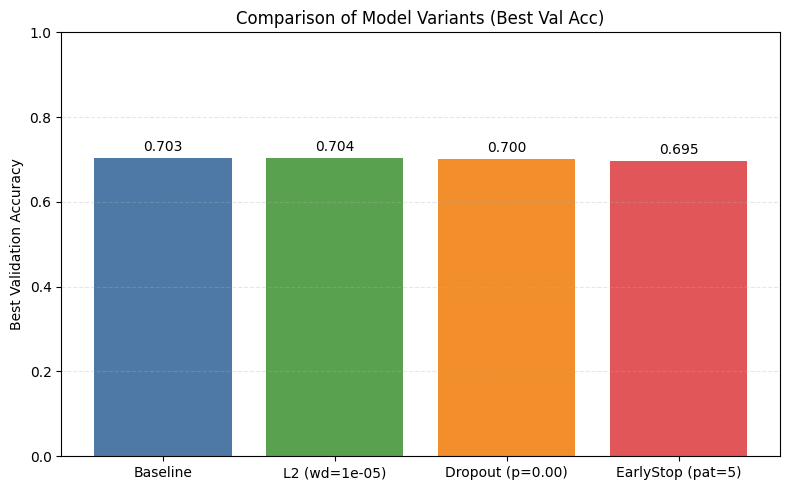

In [14]:
# 📊 Compare four model variants in one bar plot (best validation accuracy)

variants = []

# Baseline (FAST)
if 'best_fast' in globals() and isinstance(best_fast, dict) and 'val_acc' in best_fast:
    variants.append({'name': 'Baseline', 'best_val_acc': float(best_fast['val_acc'])})

# L2 sweep (pick best)
if 'l2_results' in globals() and isinstance(l2_results, dict) and len(l2_results) > 0:
    best_wd = max(l2_results.keys(), key=lambda k: l2_results[k]['best_val_acc'])
    variants.append({'name': f"L2 (wd={best_wd:g})", 'best_val_acc': float(l2_results[best_wd]['best_val_acc'])})

# Dropout sweep (pick best)
if 'dropout_results' in globals() and isinstance(dropout_results, dict) and len(dropout_results) > 0:
    best_p = max(dropout_results.keys(), key=lambda k: dropout_results[k]['best_val_acc'])
    variants.append({'name': f"Dropout (p={best_p:.2f})", 'best_val_acc': float(dropout_results[best_p]['best_val_acc'])})

# Early Stopping sweep (pick best)
if 'es_results' in globals() and isinstance(es_results, dict) and len(es_results) > 0:
    best_pat = max(es_results.keys(), key=lambda k: es_results[k]['best_val_acc'])
    variants.append({'name': f"EarlyStop (pat={best_pat})", 'best_val_acc': float(es_results[best_pat]['best_val_acc'])})

import matplotlib.pyplot as plt

if len(variants) == 0:
    print('No results found to plot. Run the training/sweeps first.')
else:
    labels = [v['name'] for v in variants]
    accs   = [v['best_val_acc'] for v in variants]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, accs, color=['#4e79a7', '#59a14f', '#f28e2b', '#e15759'][:len(labels)])
    plt.ylabel('Best Validation Accuracy')
    plt.ylim(0.0, 1.0)
    plt.title('Comparison of Model Variants (Best Val Acc)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    for bar, val in zip(bars, accs):
        plt.text(bar.get_x() + bar.get_width()/2.0, val + 0.01, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    try:
        os.makedirs(OUT_DIR, exist_ok=True)
        out_path = os.path.join(OUT_DIR, 'variant_comparison_barplot.png')
        plt.savefig(out_path, dpi=150)
        print(f"Saved bar plot to: {out_path}")
    except Exception as e:
        print(f"Could not save plot: {e}")
    plt.show()


## 10) Final Test Evaluation
Retrain each best-regularized variant on **train+valid**, then evaluate once on **test**.  
Save a bar chart of test accuracy (and/or F1) across the four runs.

Saved comparison plot to: D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\outputs_ff\accuracy_f1_comparison.png


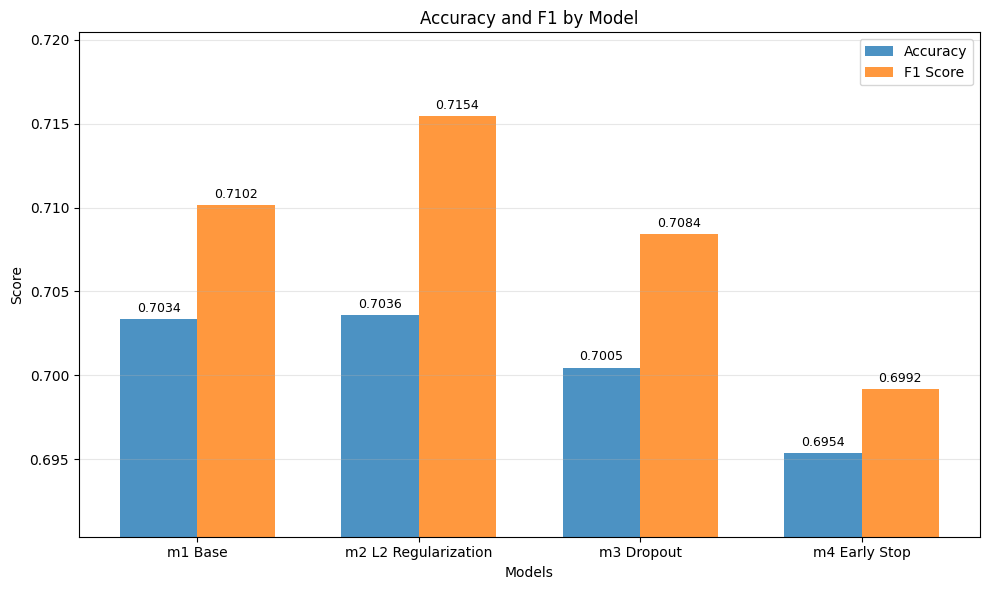


📊 Model Performance Summary:
------------------------------------------------------------
Model                Accuracy   F1 Score  
------------------------------------------------------------
m1 Base              0.7034     0.7102    
m2 L2 Regularization 0.7036     0.7154    
m3 Dropout           0.7005     0.7084    
m4 Early Stop        0.6954     0.6992    
------------------------------------------------------------


In [15]:
# 📊 Calculate F1 Scores and create Accuracy & F1 comparison bar plot

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

def calculate_f1_score(model, loader):
    """Calculate F1 score for a model on given data loader"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    
    return f1_score(all_labels, all_preds)

# Collect results for all variants
results = []

# Baseline (FAST)
if 'model_fast' in globals() and 'report_fast' in globals():
    f1_baseline = calculate_f1_score(model_fast, valid_loader_fast)
    results.append({
        'model': 'm1 Base',
        'accuracy': report_fast['accuracy'],
        'f1_score': f1_baseline
    })

# L2 (best)
if 'l2_results' in globals() and len(l2_results) > 0:
    best_wd = max(l2_results.keys(), key=lambda k: l2_results[k]['best_val_acc'])
    best_l2_model = l2_results[best_wd]['model']
    f1_l2 = calculate_f1_score(best_l2_model, valid_loader_fast)
    results.append({
        'model': 'm2 L2 Regularization',
        'accuracy': l2_results[best_wd]['final_acc'],
        'f1_score': f1_l2
    })

# Dropout (best)
if 'dropout_results' in globals() and len(dropout_results) > 0:
    best_p = max(dropout_results.keys(), key=lambda k: dropout_results[k]['best_val_acc'])
    best_dropout_model = dropout_results[best_p]['model']
    f1_dropout = calculate_f1_score(best_dropout_model, valid_loader_fast)
    results.append({
        'model': 'm3 Dropout',
        'accuracy': dropout_results[best_p]['final_acc'],
        'f1_score': f1_dropout
    })

# Early Stopping (best)
if 'es_results' in globals() and len(es_results) > 0:
    best_pat = max(es_results.keys(), key=lambda k: es_results[k]['best_val_acc'])
    best_es_model = es_results[best_pat]['model']
    f1_es = calculate_f1_score(best_es_model, valid_loader_fast)
    results.append({
        'model': 'm4 Early Stop',
        'accuracy': es_results[best_pat]['final_acc'],
        'f1_score': f1_es
    })

if len(results) == 0:
    print("No model results found. Run the training cells first.")
else:
    # Create the bar plot
    models = [r['model'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    f1_scores = [r['f1_score'] for r in results]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#1f77b4', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#ff7f0e', alpha=0.8)
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Accuracy and F1 by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Set y-axis limits to show differences better
    all_values = accuracies + f1_scores
    y_min = min(all_values) - 0.005
    y_max = max(all_values) + 0.005
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Save the plot
    try:
        os.makedirs(OUT_DIR, exist_ok=True)
        out_path = os.path.join(OUT_DIR, 'accuracy_f1_comparison.png')
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison plot to: {out_path}")
    except Exception as e:
        print(f"Could not save plot: {e}")
    
    plt.show()
    
    # Print summary table
    print("\n📊 Model Performance Summary:")
    print("-" * 60)
    print(f"{'Model':<20} {'Accuracy':<10} {'F1 Score':<10}")
    print("-" * 60)
    for r in results:
        print(f"{r['model']:<20} {r['accuracy']:<10.4f} {r['f1_score']:<10.4f}")
    print("-" * 60)


# Extra Credit: SVM on 1D Pixels

## EC1) Imports & Logging
Set up scikit-learn, lightweight logging, and utility I/O.

In [7]:
# === Extra Credit — FAST SVM: PCA(→256) + RBF SVM with logging ===

import os, time, json, math, psutil, platform
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle as sk_shuffle

from torch.utils.data import DataLoader
from tqdm import tqdm

# ---- simple timestamped logger ----
def log(msg):
    t = time.strftime("%H:%M:%S")
    print(f"[{t}] {msg}")

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

# ---- show system info once ----
log(f"Python {platform.python_version()} | NumPy {np.__version__}")
try:
    import sklearn
    log(f"scikit-learn {sklearn.__version__}")
except Exception:
    pass
try:
    import threadpoolctl
    log(f"BLAS threads: {threadpoolctl.threadpool_info()}")
except Exception:
    pass
log(f"CPU: {platform.processor()} | RAM ~{round(psutil.virtual_memory().total/1e9,1)} GB")


[16:41:40] Python 3.12.1 | NumPy 2.1.2
[16:41:40] scikit-learn 1.7.2
[16:41:40] BLAS threads: [{'user_api': 'blas', 'internal_api': 'openblas', 'num_threads': 16, 'prefix': 'libscipy_openblas', 'filepath': 'D:\\GMU Courses\\Sem-3\\DL\\Assignments\\Malaria_dataset\\myenv\\Lib\\site-packages\\numpy.libs\\libscipy_openblas64_-c16e4918366c6bc1f1cd71e28ca36fc0.dll', 'version': '0.3.27', 'threading_layer': 'pthreads', 'architecture': 'Haswell'}, {'user_api': 'openmp', 'internal_api': 'openmp', 'num_threads': 8, 'prefix': 'libiomp', 'filepath': 'D:\\GMU Courses\\Sem-3\\DL\\Assignments\\Malaria_dataset\\myenv\\Lib\\site-packages\\torch\\lib\\libiomp5md.dll', 'version': None}, {'user_api': 'openmp', 'internal_api': 'openmp', 'num_threads': 1, 'prefix': 'libiomp', 'filepath': 'D:\\GMU Courses\\Sem-3\\DL\\Assignments\\Malaria_dataset\\myenv\\Lib\\site-packages\\torch\\lib\\libiompstubs5md.dll', 'version': None}, {'user_api': 'openmp', 'internal_api': 'openmp', 'num_threads': 16, 'prefix': 'vcomp'

## EC2) Flatten to NumPy
Convert `train/valid/test` tensors to NumPy arrays of shape `(N, 12288)` with progress logs.

In [11]:
# Uses your existing BATCH_SIZE and the three *ds datasets
EC_NUM_WORKERS = 0  # set 2–4 if you want; 0 is safest/portable

def ds_to_numpy(ds, batch_size=2048, num_workers=0):
    """Stream a torchvision dataset into a (X, y) numpy pair with progress & no folder changes."""
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=False)
    X_parts, y_parts = [], []
    for xb, yb in tqdm(dl, desc="→ loading", leave=False):
        X_parts.append(xb.view(xb.size(0), -1).numpy().astype(np.float32))  # [B, 12288]
        y_parts.append(yb.numpy().astype(np.int32))
    X = np.concatenate(X_parts, axis=0)
    y = np.concatenate(y_parts, axis=0)
    return X, y

t0 = time.perf_counter()
log("Building numpy arrays from datasets …")
X_train, y_train = ds_to_numpy(train_ds, batch_size=max(1024, BATCH_SIZE), num_workers=EC_NUM_WORKERS)
X_valid, y_valid = ds_to_numpy(valid_ds, batch_size=max(1024, BATCH_SIZE), num_workers=EC_NUM_WORKERS)
X_test,  y_test  = ds_to_numpy(test_ds,  batch_size=max(1024, BATCH_SIZE), num_workers=EC_NUM_WORKERS)

log(f"Done in {time.perf_counter()-t0:.1f}s")
log(f"Shapes → train {X_train.shape}, valid {X_valid.shape}, test {X_test.shape}")

est_bytes = (X_train.nbytes + X_valid.nbytes + X_test.nbytes) / (1024**3)
log(f"Approx RAM for X arrays: {est_bytes:.2f} GiB")


[16:42:32] Building numpy arrays from datasets …


[16:46:00] Done in 208.4s
[16:46:00] Shapes → train (19291, 12288), valid (4133, 12288), test (4134, 12288)
[16:46:00] Approx RAM for X arrays: 1.26 GiB


## EC3) Standardize + PCA (Fixed)
Standardize features (fit on train only) and apply **PCA=256** to speed up SVM while preserving variance.

In [12]:
# We standardize once on TRAIN only, apply to VALID/TEST
log("Standardizing (z-score) …")
scaler = StandardScaler(with_mean=True, with_std=True)
t0 = time.perf_counter()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std  = scaler.transform(X_test)
log(f"Scaler fit+transform in {time.perf_counter()-t0:.1f}s")

# PCA outside CV so we don't recompute per fold
PCA_DIM = 256  # 256–384 are good; 256 is fast & accurate enough for this dataset
log(f"Fitting PCA to {PCA_DIM} components (randomized) …")
t0 = time.perf_counter()
pca = PCA(n_components=PCA_DIM, svd_solver="randomized", whiten=False, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_valid_pca = pca.transform(X_valid_std)
X_test_pca  = pca.transform(X_test_std)
dt = time.perf_counter()-t0
expl = float(np.sum(pca.explained_variance_ratio_))
log(f"PCA done in {dt:.1f}s | explained variance ≈ {expl:.3f}")

log(f"Shapes after PCA → train {X_train_pca.shape}, valid {X_valid_pca.shape}, test {X_test_pca.shape}")


[16:47:09] Standardizing (z-score) …
[16:47:13] Scaler fit+transform in 3.6s
[16:47:13] Fitting PCA to 256 components (randomized) …
[16:47:26] PCA done in 13.0s | explained variance ≈ 0.921
[16:47:26] Shapes after PCA → train (19291, 256), valid (4133, 256), test (4134, 256)


## EC4) RBF SVM (Small Grid)
Run a small GridSearch over `C` and `gamma` on PCA features (with verbose logs).  
Report best params and validation performance.

In [13]:
# Tiny grid; tune only on TRAIN with 3-fold CV using PCA features
# (We don't include scaler/pca in the pipeline since we already applied them above.)
log("GridSearchCV on RBF SVM (small grid) …")

param_grid = {
    "C":     [0.5, 1, 2, 4],
    "gamma": ["scale", 0.001, 0.0005],
}

svc = SVC(kernel="rbf", cache_size=2000, shrinking=True)  # cache helps; shrinking usually faster

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,   # detailed fold-level logs
    return_train_score=False
)

t0 = time.perf_counter()
grid.fit(X_train_pca, y_train)
dt = time.perf_counter() - t0

log(f"GridSearch done in {dt/60:.1f} minutes")
log(f"Best params: {grid.best_params_} | Best CV score: {grid.best_score_:.4f}")

# Validation performance (holdout)
t1 = time.perf_counter()
y_valid_pred = grid.predict(X_valid_pca)
acc_valid = accuracy_score(y_valid, y_valid_pred)
log(f"Validation accuracy (best RBF): {acc_valid:.4f} | infer {time.perf_counter()-t1:.2f}s")
print("Validation report (best RBF):\n",
      classification_report(y_valid, y_valid_pred, target_names=["Parasitized","Uninfected"]))


[16:47:32] GridSearchCV on RBF SVM (small grid) …
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[17:00:29] GridSearch done in 12.9 minutes
[17:00:29] Best params: {'C': 4, 'gamma': 'scale'} | Best CV score: 0.6632
[17:00:38] Validation accuracy (best RBF): 0.7580 | infer 9.45s
Validation report (best RBF):
               precision    recall  f1-score   support

 Parasitized       0.76      0.75      0.76      2067
  Uninfected       0.75      0.77      0.76      2066

    accuracy                           0.76      4133
   macro avg       0.76      0.76      0.76      4133
weighted avg       0.76      0.76      0.76      4133



## EC5) Test the Best SVM
Evaluate best SVM on the test set. Save JSON with metrics and confusion matrix.

In [14]:
# Evaluate once on TEST with the best estimator
best_svm = grid.best_estimator_

t0 = time.perf_counter()
y_test_pred = best_svm.predict(X_test_pca)
test_dt = time.perf_counter() - t0
acc_test = accuracy_score(y_test, y_test_pred)

log(f"TEST accuracy (best RBF): {acc_test:.4f} | inference time {test_dt:.2f}s")
svm_report = classification_report(y_test, y_test_pred,
                                   target_names=["Parasitized","Uninfected"],
                                   output_dict=True)
svm_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (SVM):\n", svm_cm)

# Save single compact JSON (no new folders created)
svm_summary = {
    "variant":        "PCA(256)+RBF SVM",
    "pca_components": PCA_DIM,
    "pca_explained_variance": expl,
    "best_params":    grid.best_params_,
    "cv_best_score":  float(grid.best_score_),
    "valid_acc":      float(acc_valid),
    "test_acc":       float(acc_test),
    "test_report":    svm_report,
    "confusion_matrix": svm_cm.tolist()
}
svm_json_path = os.path.join(OUT_DIR, "svm_pca_rbf_results.json")
save_json(svm_summary, svm_json_path)
log(f"SVM results saved → {svm_json_path}")


[17:03:56] TEST accuracy (best RBF): 0.7654 | inference time 9.72s
Confusion Matrix (SVM):
 [[1565  502]
 [ 468 1599]]
[17:03:56] SVM results saved → D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\outputs_ff\svm_pca_rbf_results.json


## EC6) Best DL vs SVM (Final Comparison)
 **Best DL** (from the fixed-architecture runs), load SVM results,  
print a tiny table + deltas, and plot a two-bar chart (Accuracy & F1).

,Model,Accuracy,F1
0,Best DL (from report),0.7036,0.7154
1,SVM (PCA256+RBF),0.7654,0.7653


Δ (SVM - DL):  Accuracy +0.0618 | F1 +0.0499


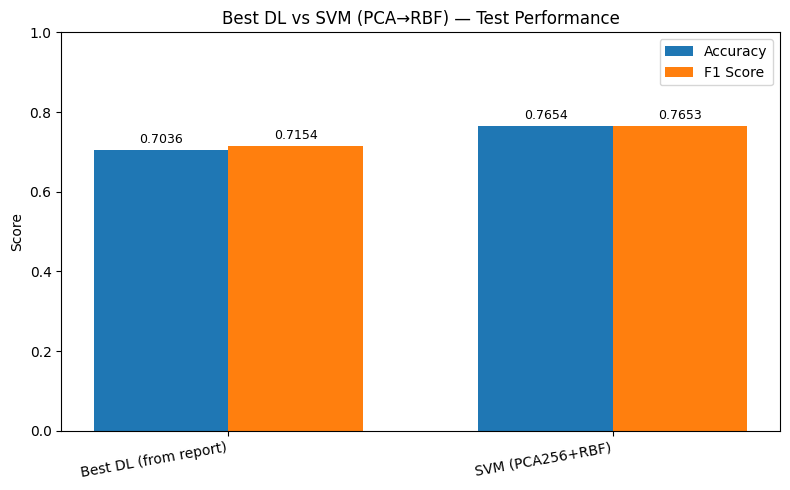

Saved plot → D:\GMU Courses\Sem-3\DL\Assignments\Malaria_dataset\outputs_ff\best_dl_vs_svm.png


In [17]:


# 1) ---- Enter your BEST DL metrics here ----
best_dl_name = "Best DL (from report)"
best_dl_acc  = 0.7036   # <-- put your best DL test accuracy
best_dl_f1   = 0.7154   # <-- put your best DL test F1

# 2) ---- Load SVM results (from memory or disk) ----
def load_svm_results():
    if "svm_summary" in globals() and isinstance(svm_summary, dict):
        return svm_summary
    p = os.path.join(OUT_DIR, "svm_pca_rbf_results.json")
    with open(p, "r") as f:
        return json.load(f)

svm_res = load_svm_results()
svm_label = f"SVM (PCA{svm_res.get('pca_components', '256')}+RBF)"
svm_acc   = float(svm_res["test_acc"])

# choose a consistent F1 (macro > weighted > average of classes)
r = svm_res.get("test_report", {})
if "macro avg" in r:
    svm_f1 = float(r["macro avg"]["f1-score"])
elif "weighted avg" in r:
    svm_f1 = float(r["weighted avg"]["f1-score"])
else:
    classes = [k for k,v in r.items() if isinstance(v, dict) and "f1-score" in v]
    svm_f1 = float(np.mean([r[k]["f1-score"] for k in classes])) if classes else float("nan")

# 3) ---- Table + deltas ----
df = pd.DataFrame([
    {"Model": best_dl_name, "Accuracy": best_dl_acc, "F1": best_dl_f1},
    {"Model": svm_label,    "Accuracy": svm_acc,     "F1": svm_f1},
])
display(df.style.format({"Accuracy":"{:.4f}", "F1":"{:.4f}"}))

print(f"Δ (SVM - DL):  Accuracy {svm_acc - best_dl_acc:+.4f} | F1 {svm_f1 - best_dl_f1:+.4f}")

# 4) ---- Bar chart (two models, Acc & F1) ----
labels = [best_dl_name, svm_label]
x = np.arange(2); width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, [best_dl_acc, svm_acc], width, label="Accuracy")
rects2 = ax.bar(x + width/2, [best_dl_f1, svm_f1],   width, label="F1 Score")

ax.set_ylabel("Score"); ax.set_ylim(0, 1.0)
ax.set_title("Best DL vs SVM (PCA→RBF) — Test Performance")
ax.set_xticks(x, labels, rotation=10, ha="right"); ax.legend()

for rct in list(rects1)+list(rects2):
    h = rct.get_height()
    ax.annotate(f"{h:.4f}", xy=(rct.get_x()+rct.get_width()/2, h),
                xytext=(0,3), textcoords="offset points", ha="center", va="bottom", fontsize=9)

fig.tight_layout()
out_png = os.path.join(OUT_DIR, "best_dl_vs_svm.png")
plt.savefig(out_png, bbox_inches="tight", dpi=150)
plt.show()
print(f"Saved plot → {out_png}")
